In [1]:
%matplotlib notebook
import csv
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product, zip_longest
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, PredefinedSplit, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from datetime import timedelta

In [2]:
outDir = ''  # change as necessary
path = Path(outDir)
path_confirmed = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
path_recovered = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
path_deaths = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
plt.close('all')

In [3]:
def preprocess(filepath, growth_period=1):
    """
    file_path: Path to .csv file (containing information on confirmed cases or recovered cases or deaths) of size Number_of_Regions x (Total_Days+4)
    growth_period: compute average growth every growth_period number of days
    
    return df_daily, df_cum, df_growth of shape Total_Days x Number_of_Countries
    """
    df_raw = pd.read_csv(filepath)
    
    df_daily = pd.DataFrame(index=pd.to_datetime(df_raw.columns[4:]))
    df_cum = pd.DataFrame(index=pd.to_datetime(df_raw.columns[4:]))
    df_growth = pd.DataFrame(index=pd.to_datetime(df_raw.columns[4:]))
    
    countries = set(df_raw['Country/Region'])
    
    for country in countries:
        # hard-coding start of dates column number (double check with any updated dataset)
        df_cum[country] = df_raw[df_raw['Country/Region'] == country].iloc[:,4:].sum(axis=0).values  
        df_daily[country] = df_cum[country].diff().fillna(df_cum[country].iloc[0])  # NaN at first instance only
        df_growth[country] = (df_cum[country].diff(periods=growth_period).fillna(df_cum[country].iloc[0]))/(growth_period*df_cum[country])
    
    return df_raw, df_daily, df_cum, df_growth

In [4]:
def predict_ultimate_outcome(filepath, case_type, countries, model, growth_period, linear_after, p, save_dir, plot=True, save=False):
    """
    file_path: Path to .csv file (containing information on confirmed cases or deaths) of size Number_of_Regions x (Total_Days+4)
    case_type: 'Confirmed' or 'Death'; for plotting purpose
    countries: list of countries for which results desired
    model: regressor to be used e.g. LinearRegression() or Lasso()
    growth_period: compute average growth every growth_period number of days
    linear_after: number of days after which growth vs cumulative cases follows linear trend (better to compute it rather than send it as input)
    p: we define the end time of the epidemic when the number of cases reaches the fraction 1 − p of total cases
    
    returns dataframe with information on 'N_inf' i.e. predicted total deaths/ confirmed cases,
    'N_0' i.e. total cases at time when linear relationship emerges,
    't' i.e. days after linear relationship emerges that the epidemic will end,
    outbreak_end_date, which is simply the date found using 't' for convenience of analysis, and some other numbers (see paper)
    """
    res = pd.DataFrame(index=['lamda_0/N_inf', 'lamda_0', 'N_inf', 'N_0', 't', 'outbreak_end_date'])
    
    df_raw, df_daily, df_cum, df_growth = preprocess(filepath, growth_period)
    
    for country in countries:
        # use try block to circumvent issues like division by zero (which I do not want to handle using small epsilon due to nature of values),
        # and that in expected linear region as dictated by hard-inputted linear_after there may be no value for some country
        try:
            outbreak_start_date = df_cum[country].ne(0).idxmax()  # outbreak starts when first non-zero value (of deaths/ confirmed depending on data) appears
            outbreak_start_index = df_cum.index.get_loc(outbreak_start_date)
    
            X = df_cum[country].iloc[outbreak_start_index+growth_period:].values.reshape(-1,1)

            # training only on linear data
            X_train = df_cum[country].iloc[outbreak_start_index+linear_after:].values.reshape(-1,1)
            y_train = df_growth[country].iloc[outbreak_start_index+linear_after:].values.reshape(-1,1)

            reg = model.fit(X_train, y_train)
            pred = reg.predict(X)
    
            m = float(reg.coef_)
            lamda_0 = float(reg.intercept_)
            N_inf = abs(lamda_0/m)
            N_0 = df_cum[country].iloc[outbreak_start_index+linear_after]
            t = (1/lamda_0) * np.log((N_inf-N_0)/(N_0*p))
            outbreak_end_date = outbreak_start_date + timedelta(days=linear_after+math.ceil(t))
            res[country] = [m, lamda_0, N_inf, N_0, t, outbreak_end_date.date()]
        
            if plot:
                plt.figure()
                plt.plot(df_cum[country].iloc[outbreak_start_index+growth_period:], df_d_growth[country].iloc[outbreak_start_index+growth_period:], linestyle='--', marker='o')
                plt.plot(X, pred)
                plt.xlabel(f'Cumulative Number of {case_type} Cases')
                plt.ylabel('Growth Rate')
                plt.title(country)
                plt.legend(['Actual', 'Prediction'])
            
            if save: 
                if not os.path.isdir(save_dir + f'/{case_type}'):
                    os.makedirs(save_dir + f'/{case_type}')
                plt.savefig(fname = save_dir + f"/{case_type}/{country}_{str(model).split('(')[0]}_gp{growth_period}_la{linear_after}.jpg", quality = 95)
        
        except:
            pass
    
    return res

In [5]:
df_d_raw, df_d_daily, df_d_cum, df_d_growth = preprocess(path_deaths, growth_period=2)

# testing on top_n number of countries sorted by most deaths
top_n = 25  # predict_ultimate_outcomes() will ignore unanalyzable countries itself
countries = list(df_d_cum.iloc[df_d_cum.shape[0]-1,:].sort_values(ascending=False)[:top_n].keys())
# countries = ['China', 'Italy', 'Iran', 'US', 'Pakistan', 'India']

fpath = path_confirmed
save_dir = outDir + 'DT_Paper/Graphs'
case_type = 'confirmed'
model = LinearRegression()
# model = Ridge()
# model = Lasso()
growth_period = 2
linear_after = 4
p = 0.015

<IPython.core.display.Javascript object>


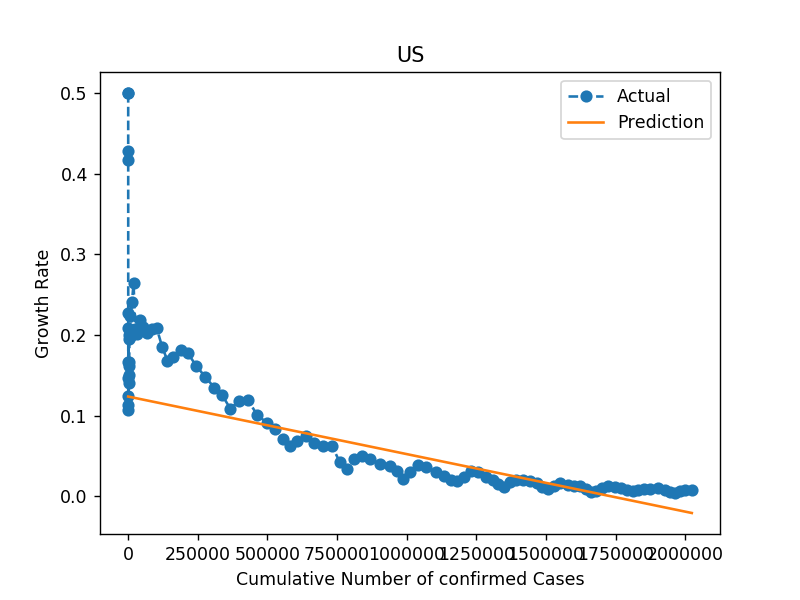

<IPython.core.display.Javascript object>


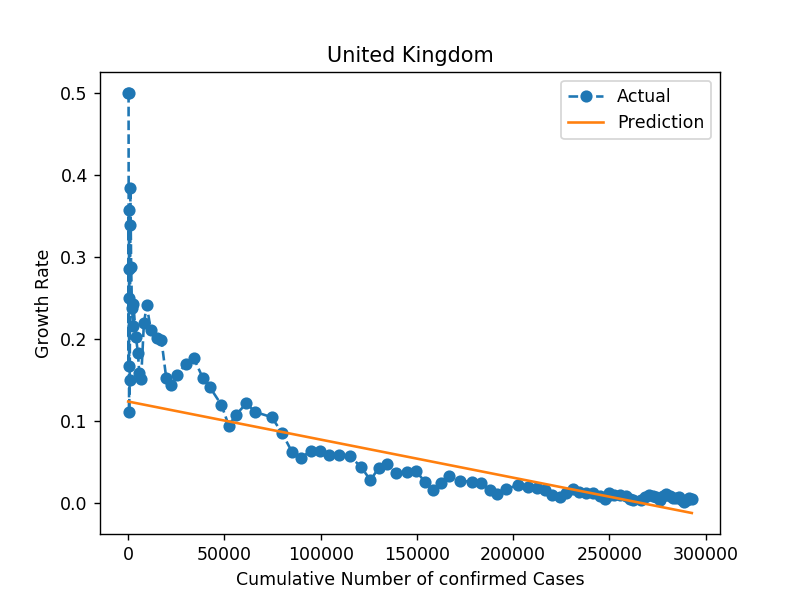

<IPython.core.display.Javascript object>


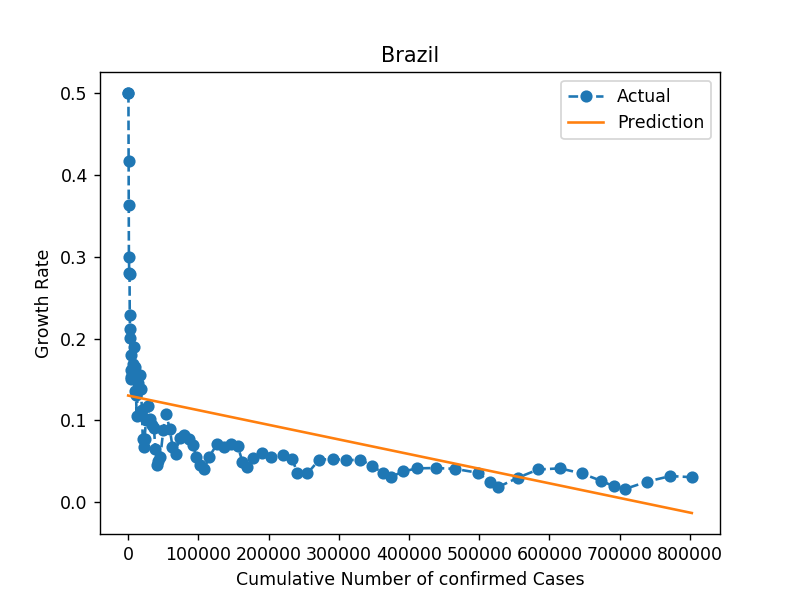

<IPython.core.display.Javascript object>


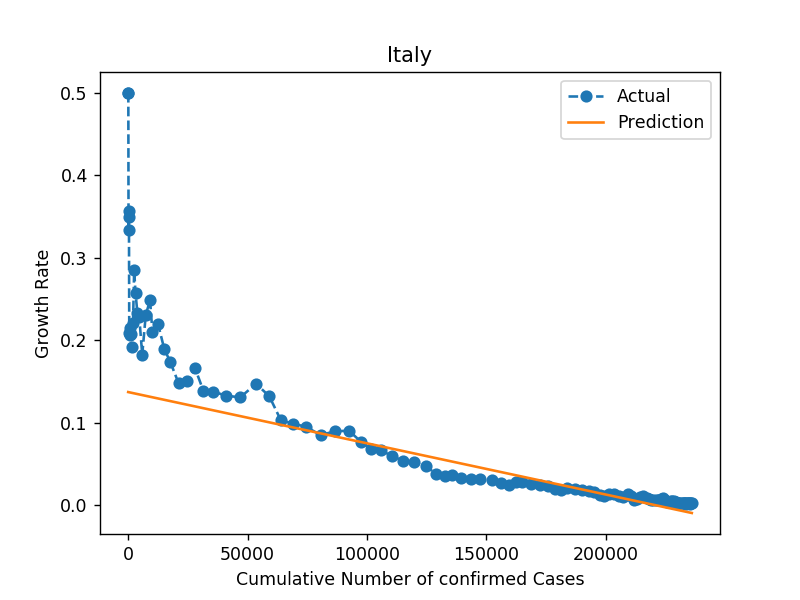

<IPython.core.display.Javascript object>


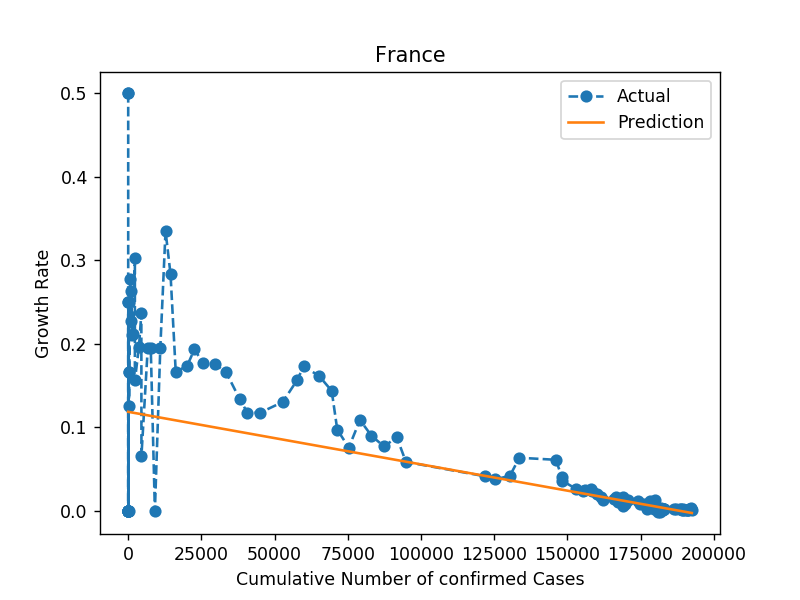

<IPython.core.display.Javascript object>


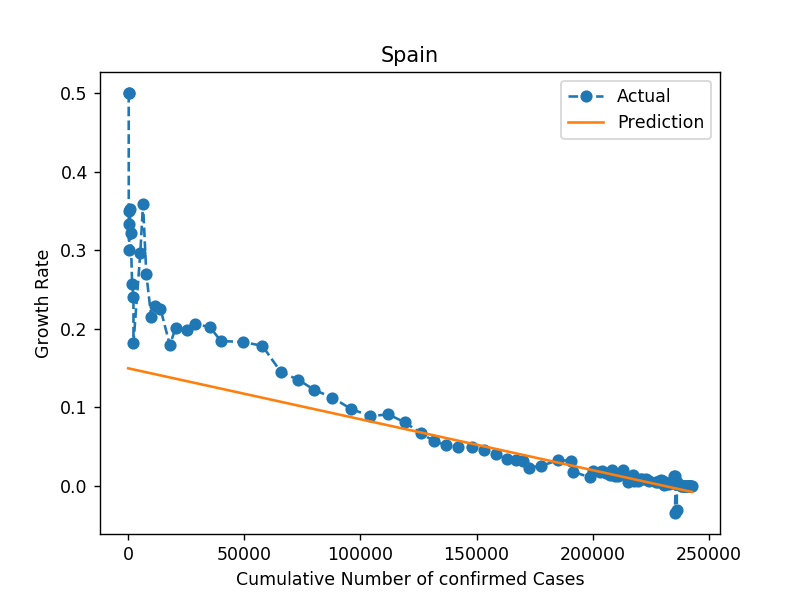

<IPython.core.display.Javascript object>


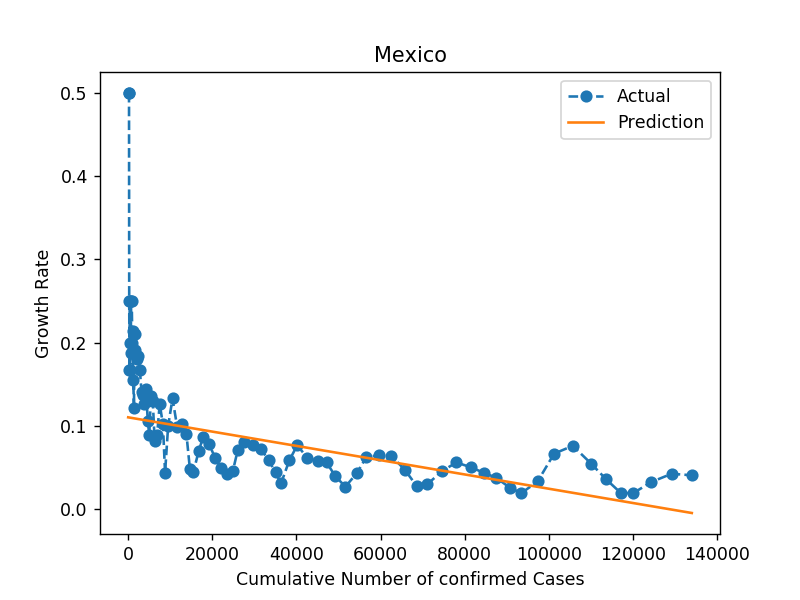

<IPython.core.display.Javascript object>


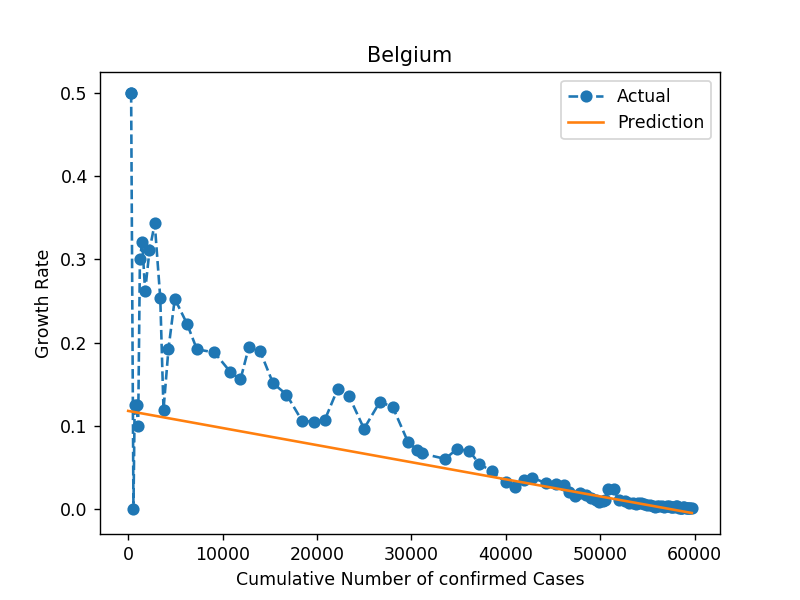

<IPython.core.display.Javascript object>


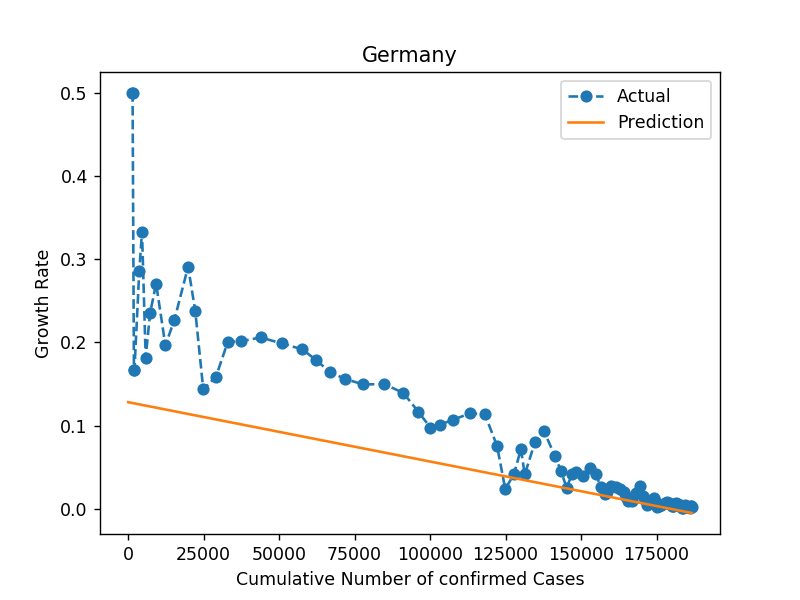

<IPython.core.display.Javascript object>


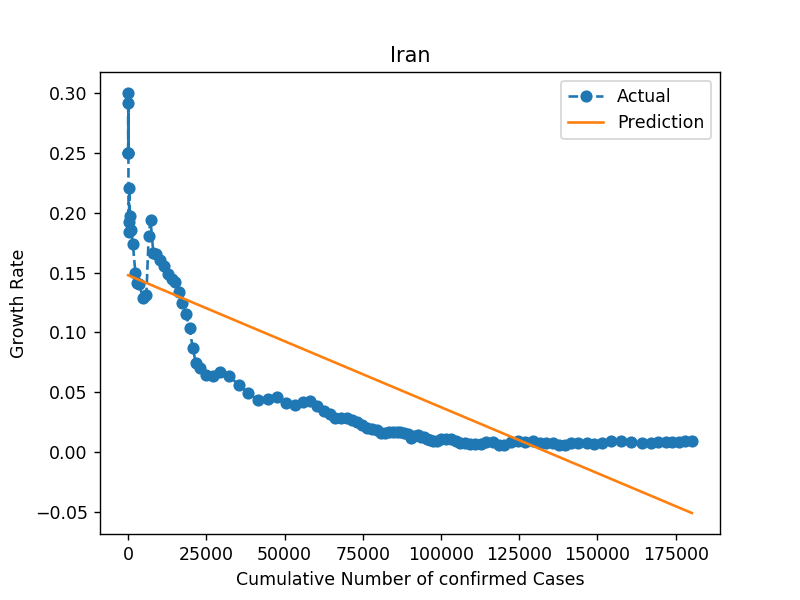

<IPython.core.display.Javascript object>


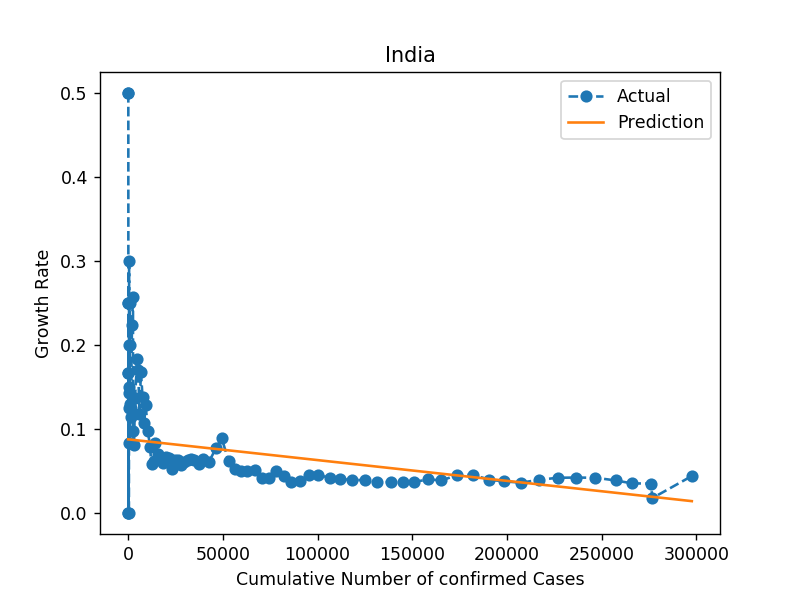

<IPython.core.display.Javascript object>


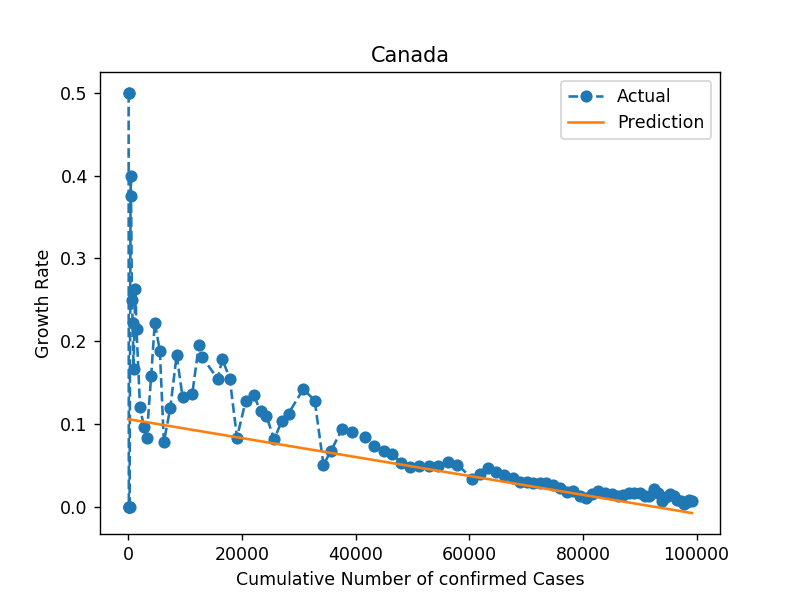

<IPython.core.display.Javascript object>


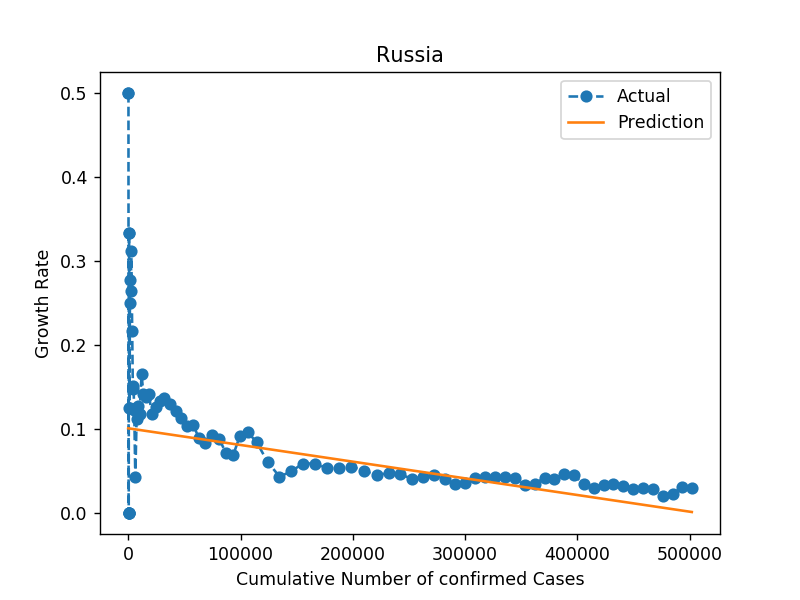

<IPython.core.display.Javascript object>


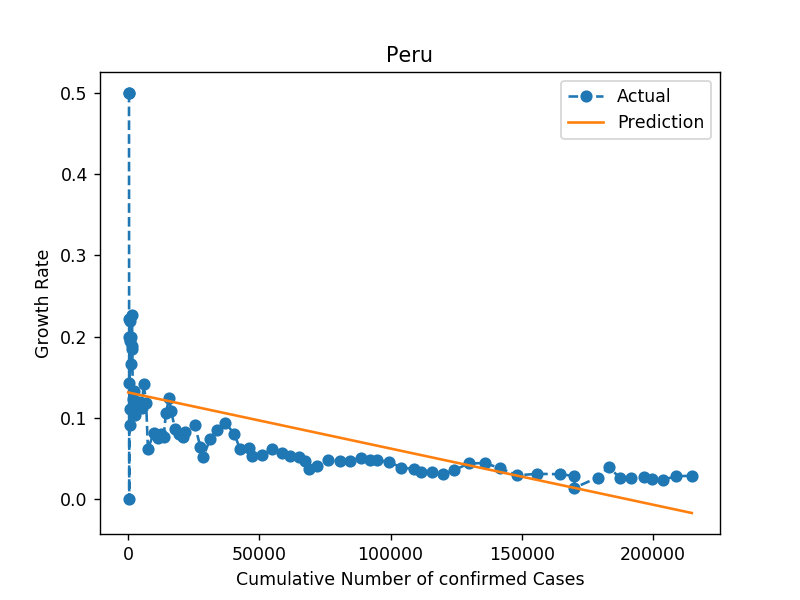

<IPython.core.display.Javascript object>


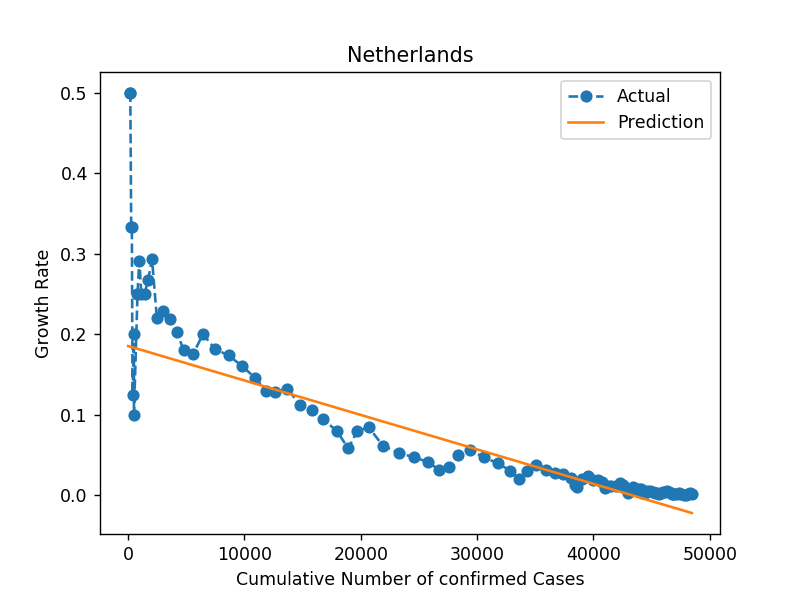

<IPython.core.display.Javascript object>


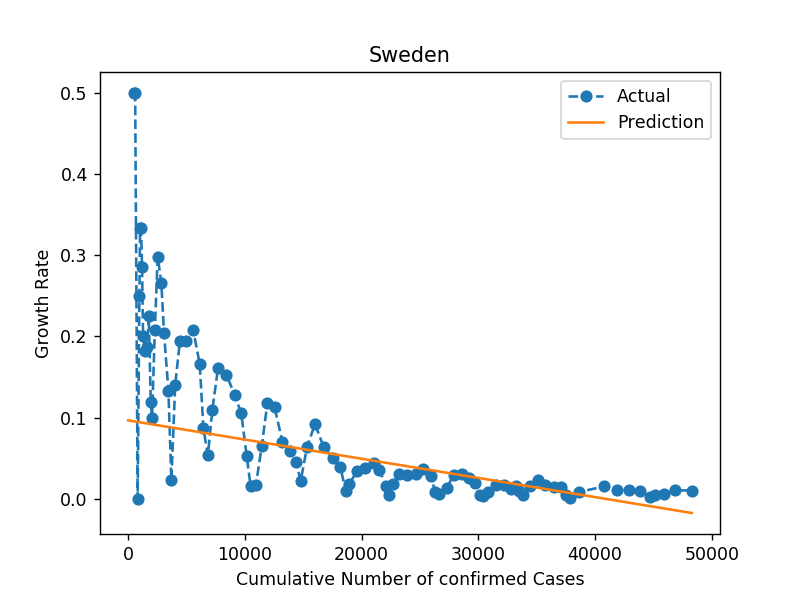

<IPython.core.display.Javascript object>


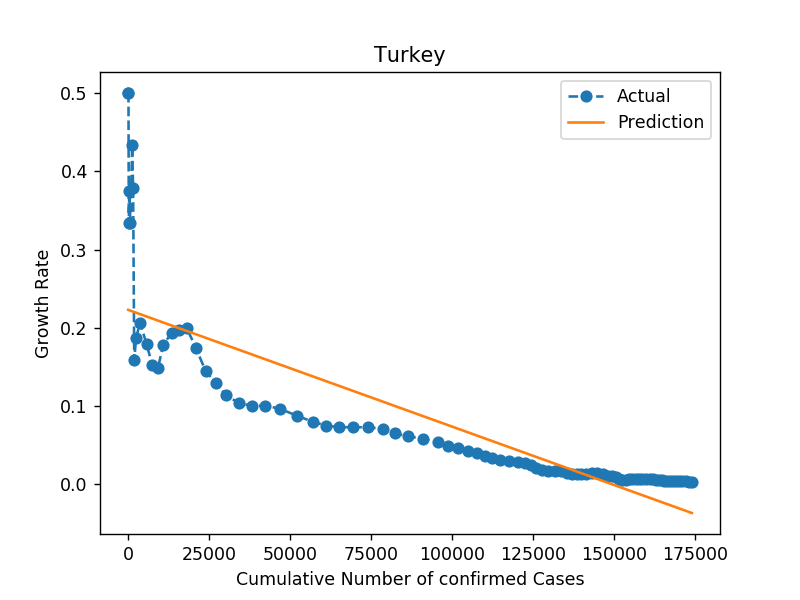

<IPython.core.display.Javascript object>


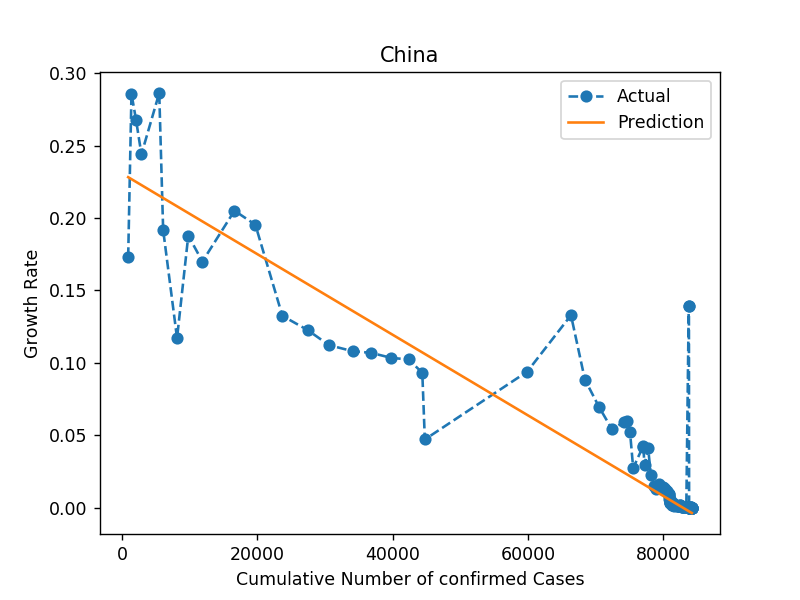

<IPython.core.display.Javascript object>


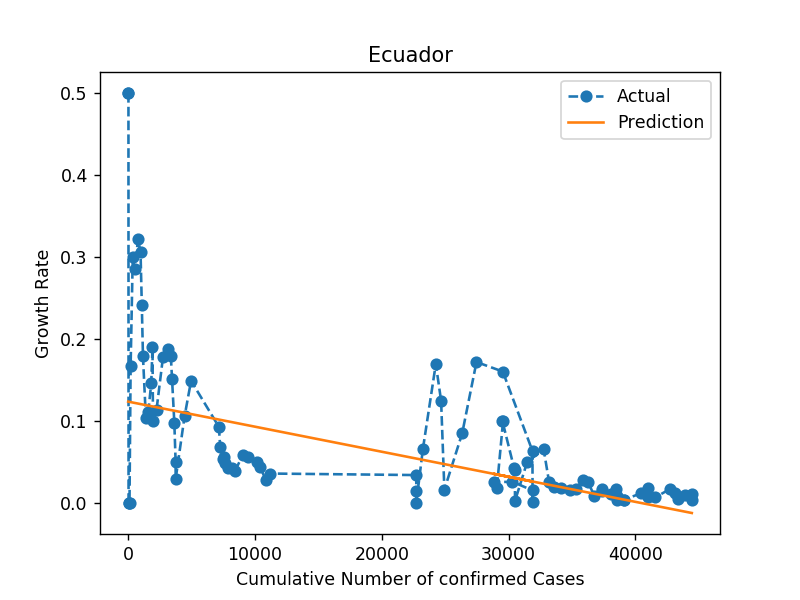

<IPython.core.display.Javascript object>


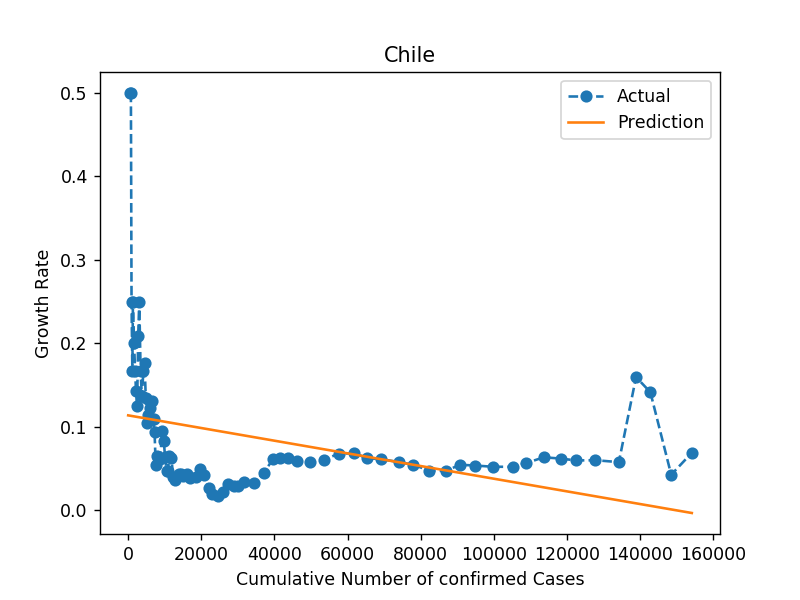

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


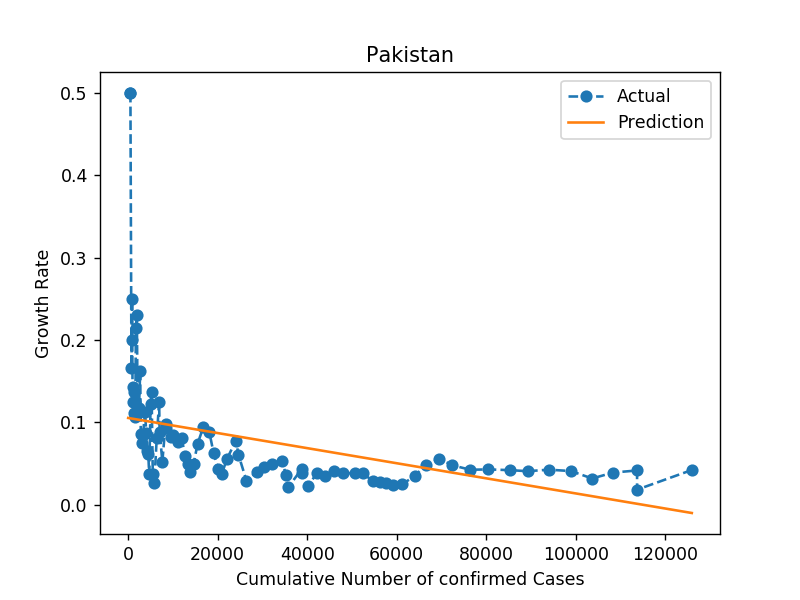

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


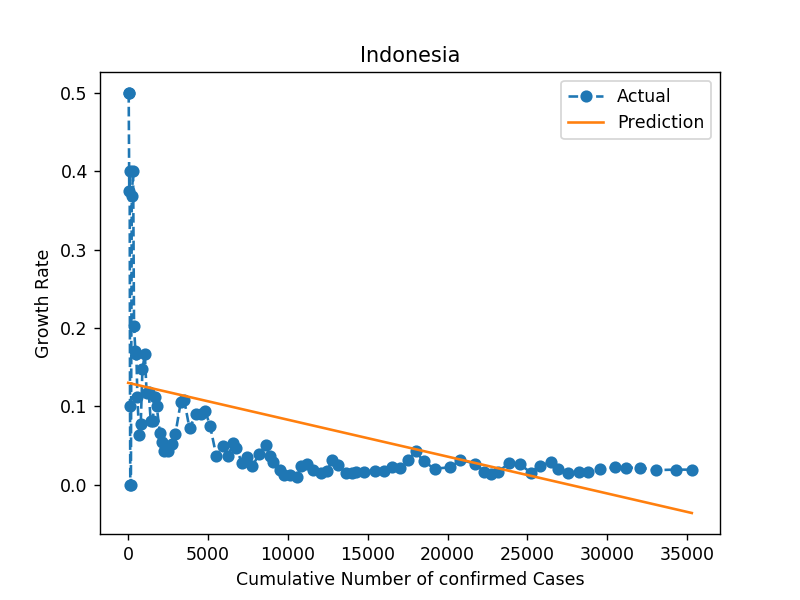

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


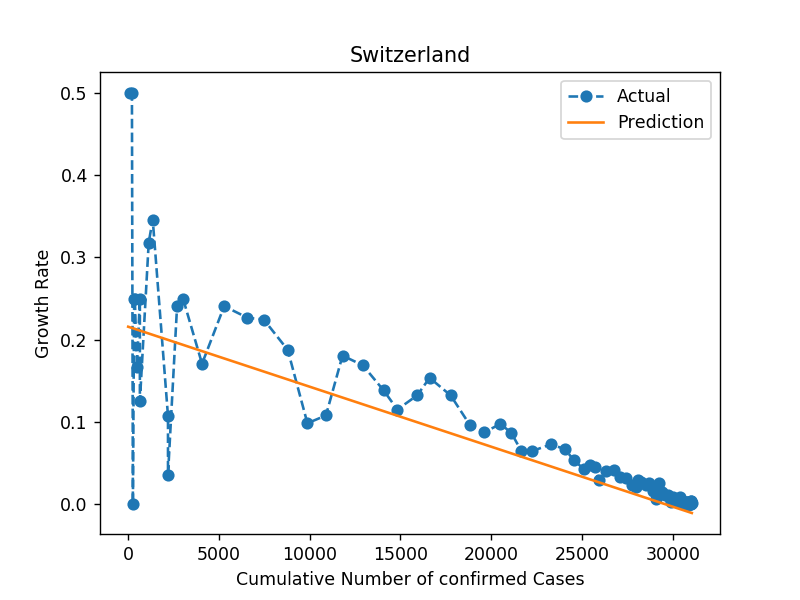

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


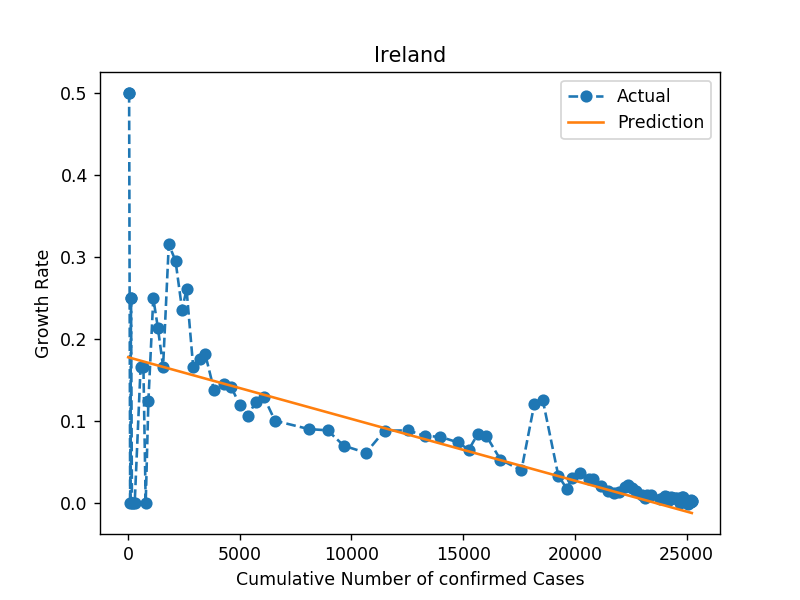

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


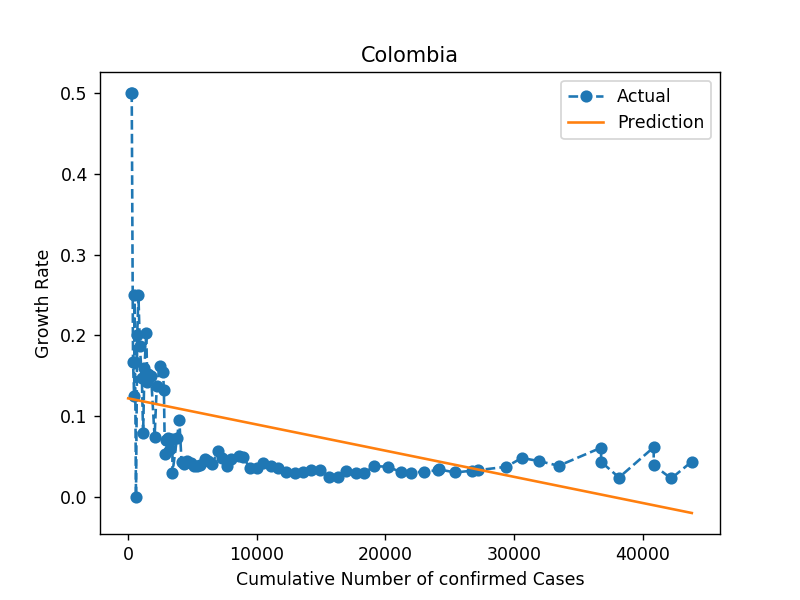

In [6]:
prediction = predict_ultimate_outcome(fpath, case_type, countries, model, growth_period, linear_after, p, save_dir, plot=True, save=True)

In [7]:
prediction

,US,United Kingdom,Brazil,Italy,France,Spain,Mexico,Belgium,Germany,Iran,...,Sweden,Turkey,China,Ecuador,Chile,Pakistan,Indonesia,Switzerland,Ireland,Colombia
lamda_0/N_inf,-7.13457e-08,-4.64076e-07,-1.78711e-07,-6.2158e-07,-6.28936e-07,-6.48094e-07,-8.58114e-07,-2.05363e-06,-7.13955e-07,-1.10239e-06,...,-2.36338e-06,-1.49111e-06,-2.78401e-06,-3.05803e-06,-7.59236e-07,-9.16365e-07,-4.70607e-06,-7.29949e-06,-7.51773e-06,-3.2389e-06
lamda_0,0.123726,0.123819,0.130429,0.137018,0.118539,0.149743,0.110262,0.118099,0.12815,0.147795,...,0.0965777,0.222994,0.230683,0.123474,0.113763,0.105442,0.130088,0.215813,0.178092,0.122111
N_inf,1.73418e+06,266808,729833,220434,188475,231052,128493,57507.5,179493,134068,...,40864.3,149550,82860.2,40377.1,149839,115065,27642.6,29565.5,23689.6,37701.3
N_0,5,2,2,2,4,1,5,1,5,43,...,1,6,2075,13,4,4,4,18,6,3
t,137.047,129.228,130.394,115.386,126.204,110.523,130.18,128.361,114.617,82.8462,...,153.428,64.2317,34.0793,99.1338,129.486,137.2,100.243,53.7646,70.079,111.689
outbreak_end_date,2020-06-12,2020-06-13,2020-07-10,2020-05-30,2020-06-03,2020-05-26,2020-07-12,2020-06-16,2020-05-25,2020-05-16,...,2020-07-07,2020-05-19,2020-03-01,2020-06-13,2020-07-15,2020-07-16,2020-06-15,2020-04-23,2020-05-14,2020-06-30


All code above is sufficient for testing purpose. Below is some data exploration I initially performed, which I leave in its serene form, for understanding purposes.

## Dataset Exploration

In [9]:
outDir = ''  # change as necessary
path = Path(outDir)
path_confirmed = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
path_recovered = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
path_deaths = path/'data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

df_c_u = pd.read_csv(path_confirmed)  # DataFrame containing Confirmed cases, Unpreprocessed
df_r_u = pd.read_csv(path_recovered)
df_d_u = pd.read_csv(path_deaths)

In [10]:
df_c_u.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,484,484,485,499,499,513,513,514,611,632
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,399,419,453,469,482,484,496,524,560,591
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,132,132,132,132,141,141,141,141,162,162
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,4100,4191,4289,4370,4453,4529,4609,4690,4763,4834
265,NaN,Lesotho,-29.609988,28.233608,0,0,0,0,0,0,...,2,4,4,4,4,4,4,4,4,4


In [11]:
# data contains cumulative cases (non-decreasing)
# work with that as well as cases each day
# work with cases each day as well as cumulative cases (non-decreasing)
df_c_cum = pd.DataFrame(index=pd.to_datetime(df_c_u.columns[4:]))
df_r_cum = pd.DataFrame(index=pd.to_datetime(df_r_u.columns[4:]))
df_d_cum = pd.DataFrame(index=pd.to_datetime(df_d_u.columns[4:]))
df_c = pd.DataFrame(index=pd.to_datetime(df_c_u.columns[4:]))
df_r = pd.DataFrame(index=pd.to_datetime(df_r_u.columns[4:]))
df_d = pd.DataFrame(index=pd.to_datetime(df_d_u.columns[4:]))
df_c_growth = pd.DataFrame(index=pd.to_datetime(df_c_u.columns[4:]))
df_r_growth = pd.DataFrame(index=pd.to_datetime(df_r_u.columns[4:]))
df_d_growth = pd.DataFrame(index=pd.to_datetime(df_d_u.columns[4:]))
df_net_infected = pd.DataFrame(index=pd.to_datetime(df_c_u.columns[4:]))
countries = set(df_c_u['Country/Region'])
for country in countries:
    df_c_cum[country] = df_c_u[df_c_u['Country/Region'] == country].iloc[:,4:].sum(axis=0).values  # hard-coding start of dates (double check with any updated dataset)
    df_r_cum[country] = df_r_u[df_c_u['Country/Region'] == country].iloc[:,4:].sum(axis=0).values
    df_d_cum[country] = df_d_u[df_c_u['Country/Region'] == country].iloc[:,4:].sum(axis=0).values
    
    df_c[country] = df_c_cum[country].diff().fillna(df_c_cum[country].iloc[0])  # NaN at first instance only
    df_r[country] = df_r_cum[country].diff().fillna(df_r_cum[country].iloc[0])
    df_d[country] = df_d_cum[country].diff().fillna(df_d_cum[country].iloc[0])
    
    df_c_growth[country] = df_c[country]/df_c_cum[country]
    df_r_growth[country] = df_r[country]/df_r_cum[country]
    df_d_growth[country] = (0.5*df_d_cum[country].diff(periods=2).fillna(df_d_cum[country].iloc[0]))/df_d_cum[country]
    # Since the reporting of death cases is uneven, deaths are sometimes reported a day later. Therefore we calculate the daily rate from the average of two consecutive days λn = 0.5 · (Nn − Nn−2)/Nn
    
    df_net_infected[country] = df_c_cum[country] - df_r_cum[country]

C:\Users\shasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
df_net_infected.tail()  # confirmed - recovered (!= resolved since deaths also included in that)

,Sudan,Uruguay,Chad,Czechia,China,Holy See,Belize,Iran,Spain,Netherlands,...,Seychelles,Egypt,Bulgaria,Libya,Indonesia,Austria,Trinidad and Tobago,Latvia,Turkey,Liberia
2020-06-07,6081,115,692,8323,-13594,-134337,8,156799,239536,45061,...,-1378,28279,2589,233,30781,1109,9,-2811,32163,-6315
2020-06-08,6242,107,694,8318,-15710,-136348,8,158789,239658,45224,...,-1385,29644,2672,308,31628,1129,8,-2813,29741,-6324
2020-06-09,6427,92,699,8332,-15921,-138445,9,160786,239839,44803,...,-1391,31029,2751,335,32671,1104,8,-2813,27516,-6592
2020-06-10,6582,89,701,8386,-16187,-140578,9,162721,240078,44983,...,-1393,32484,2855,354,33909,1095,8,-2812,26197,-6617
2020-06-11,6730,75,703,8351,-17036,-142651,9,164923,240429,45145,...,-1398,33526,2948,369,34887,1085,8,-2816,26163,-6655


In [13]:
df_c_cum['China'].tail()

2020-06-07    84191
2020-06-08    84195
2020-06-09    84198
2020-06-10    84209
2020-06-11    84216
Name: China, dtype: int64

In [14]:
df_d_growth['China'].head(10)

2020-01-22    0.500000
2020-01-23    0.472222
2020-01-24    0.173077
2020-01-25    0.285714
2020-01-26    0.267857
2020-01-27    0.243902
2020-01-28    0.286260
2020-01-29    0.191729
2020-01-30    0.116959
2020-01-31    0.187793
Name: China, dtype: float64

In [15]:
df_c_W = df_c.resample('W').sum()  # too little data for date aggregation right now
df_c_W

,Sudan,Uruguay,Chad,Czechia,China,Holy See,Belize,Iran,Spain,Netherlands,...,Seychelles,Egypt,Bulgaria,Libya,Indonesia,Austria,Trinidad and Tobago,Latvia,Turkey,Liberia
2020-01-26,0.0,0.0,0.0,0.0,2075.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,0.0,14555.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-09,0.0,0.0,0.0,0.0,23199.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-16,0.0,0.0,0.0,0.0,30684.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0,6509.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,0.0,0.0,0.0,3.0,2910.0,0.0,0.0,935.0,82.0,10.0,...,0.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,28.0,891.0,1.0,0.0,5588.0,589.0,255.0,...,0.0,47.0,4.0,0.0,6.0,90.0,0.0,2.0,0.0,0.0
2020-03-15,1.0,8.0,0.0,222.0,180.0,0.0,0.0,7372.0,7125.0,873.0,...,2.0,61.0,47.0,0.0,111.0,756.0,2.0,28.0,6.0,0.0
2020-03-22,1.0,150.0,1.0,867.0,432.0,0.0,0.0,7700.0,20970.0,3079.0,...,5.0,217.0,136.0,0.0,397.0,2722.0,48.0,109.0,1230.0,3.0
2020-03-29,4.0,151.0,2.0,1697.0,687.0,5.0,2.0,16671.0,51342.0,6713.0,...,1.0,282.0,159.0,8.0,771.0,5206.0,28.0,208.0,7981.0,0.0


In [16]:
t = 10000
df_imp_dates = pd.DataFrame(index=['First Confirmed Case Date', 'First Death Date', f'More Than {t} Confirmed Cases Date', f'Days to {t} Confirmed Cases', 'Days Since First Case', f'Days since {t} Cases'])

all_countries = df_c.columns.values

for country in all_countries:
    date_latest_data = df_c_cum[country].tail(1).index.date
    outbreak_start_date = df_c_cum[country].ne(0).idxmax().date()  # outbreak starts when first non-zero value appears
    outbreak_start_index = df_c_cum.index.get_loc(outbreak_start_date)
    death_start_date = df_d_cum[country].ne(0).idxmax().date()
    gt_t_date = df_c_cum[country].gt(t).idxmax().date()
    gt_t_index = df_c_cum[country].index.get_loc(gt_t_date)
    if death_start_date < outbreak_start_date: # can use == first date but this is more interpretable
        death_start_date = 'N/A'
    if gt_t_date <= outbreak_start_date and country != 'China':
        # gt_t_date = 'N/A'
        continue
    days_since_outbreak = df_c_cum.shape[0]-1-outbreak_start_index
    days_since_t_cases = df_c_cum.shape[0]-1-gt_t_index
    days_to_t = float((gt_t_date - outbreak_start_date).days)
    df_imp_dates[country] = [outbreak_start_date, death_start_date, gt_t_date, days_to_t, days_since_outbreak, days_since_t_cases]

df_imp_dates

,China,Iran,Spain,Netherlands,Oman,Serbia,Nigeria,Armenia,France,Ukraine,...,Japan,Bahrain,Panama,US,Germany,Italy,Egypt,Indonesia,Austria,Turkey
First Confirmed Case Date,2020-01-22,2020-02-19,2020-02-01,2020-02-27,2020-02-24,2020-03-06,2020-02-28,2020-03-01,2020-01-24,2020-03-03,...,2020-01-22,2020-02-24,2020-03-10,2020-01-22,2020-01-27,2020-01-31,2020-02-14,2020-03-02,2020-02-25,2020-03-11
First Death Date,2020-01-22,2020-02-19,2020-03-03,2020-03-06,2020-03-31,2020-03-20,2020-03-23,2020-03-26,2020-02-15,2020-03-13,...,2020-02-13,2020-03-16,2020-03-11,2020-02-29,2020-03-09,2020-02-21,2020-03-08,2020-03-11,2020-03-12,2020-03-17
More Than 10000 Confirmed Cases Date,2020-02-01,2020-03-12,2020-03-17,2020-03-29,2020-05-30,2020-05-09,2020-05-31,2020-06-02,2020-03-19,2020-04-30,...,2020-04-18,2020-05-28,2020-05-21,2020-03-19,2020-03-18,2020-03-10,2020-05-12,2020-04-30,2020-03-31,2020-03-30
Days to 10000 Confirmed Cases,10,22,45,31,96,64,93,93,55,58,...,87,94,72,57,51,39,88,59,35,19
Days Since First Case,141,113,131,105,108,97,104,102,139,100,...,141,108,93,141,136,132,118,101,107,92
Days since 10000 Cases,131,91,86,74,12,33,11,9,84,42,...,54,14,21,84,85,93,30,42,72,73


In [17]:
df_c_cum['Pakistan'].tail()

2020-06-07    103671
2020-06-08    108317
2020-06-09    113702
2020-06-10    113702
2020-06-11    125933
Name: Pakistan, dtype: int64

<IPython.core.display.Javascript object>


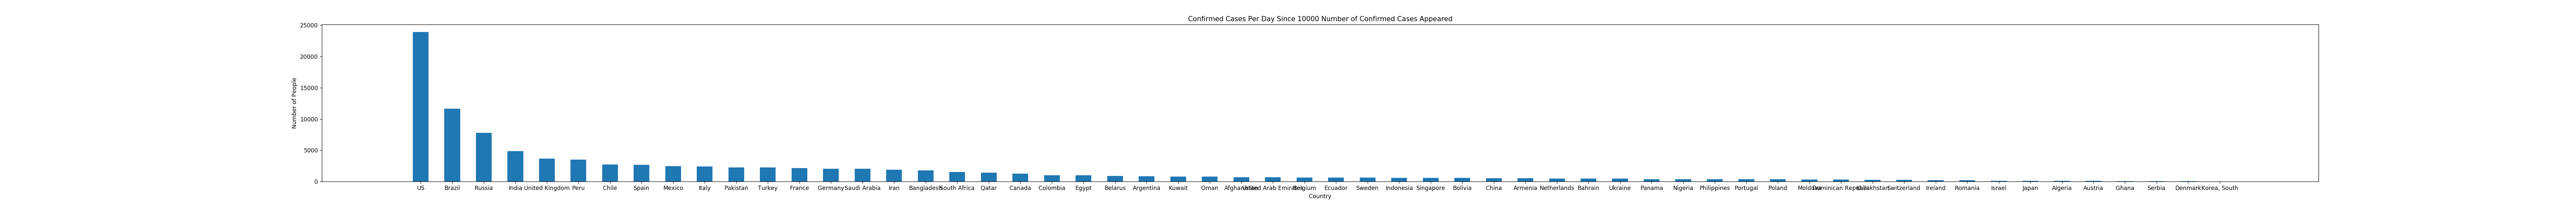

<IPython.core.display.Javascript object>


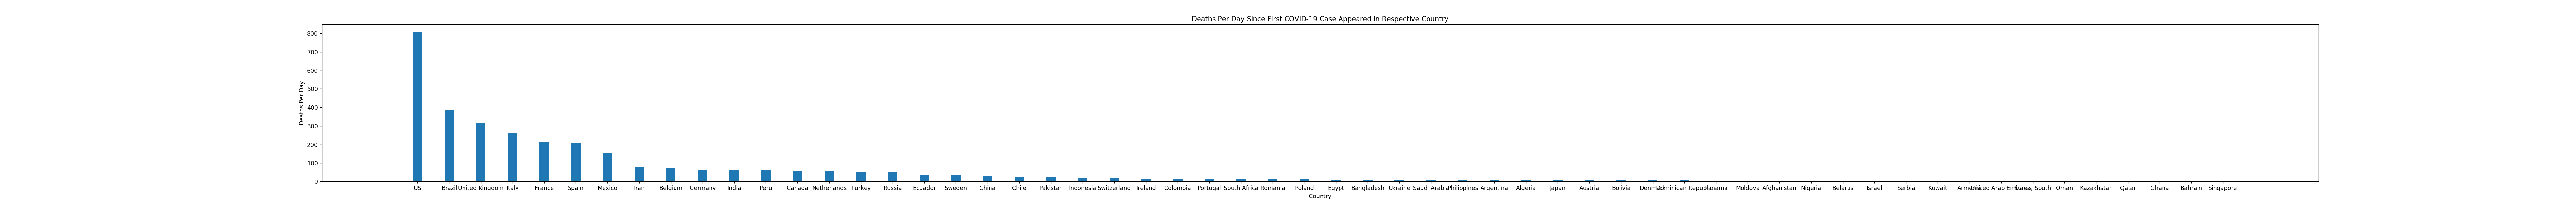

In [18]:
top_n = df_imp_dates.shape[1]-1
# top_n = 20
fastest_countries = list(df_imp_dates.iloc[3,:].sort_values(ascending=True)[:top_n].keys())
num_days = []
cum_deaths = []
cum_conf = []
avg_deaths_per_day_since_outbreak = []
avg_confirmed_per_day_since_high = []

# remove the biggest names for now for convenient visualization
# fastest_countries.remove('China')
# fastest_countries.remove('Iran')
# fastest_countries.remove('Italy')

for c in fastest_countries:
    nd = df_imp_dates[c].iloc[3]
    cd = int(df_d_cum[c].tail(1).values)
    ad_pd_so = float(cd)/float(df_imp_dates[c].iloc[4])
    cc = int(df_c_cum[c].tail(1).values)
    
    first_high_day = df_c_cum[c].index.get_loc(df_imp_dates[c].iloc[2])
    first_high_count = df_c_cum[c].iloc[first_high_day]
    today = df_c_cum[c].shape[0]-1
    current_count = df_c_cum[c].iloc[today]
    if today != first_high_day:
        ac_sh = float(current_count-first_high_count)/float(today-first_high_day)
    else:
        ac_sh = -1
    
    num_days.append(nd)
    cum_deaths.append(cd)
    avg_deaths_per_day_since_outbreak.append(ad_pd_so)
    cum_conf.append(cc)
    avg_confirmed_per_day_since_high.append(ac_sh)

ind = [i for i in range(len(fastest_countries))]

ac_v_c = list(zip(avg_confirmed_per_day_since_high, fastest_countries))  # Average Confirmed Vs Country
ac_v_c = sorted(ac_v_c, key=lambda x: x[0], reverse=True)
unzipped1 = [list(t) for t in zip(*ac_v_c)]
avg_confirmed_sorted, c_sorted1 = unzipped1[0], unzipped1[1]

ad_v_c = list(zip(avg_deaths_per_day_since_outbreak, fastest_countries))
ad_v_c = sorted(ad_v_c, key=lambda x: x[0], reverse=True)
unzipped2 = [list(t) for t in zip(*ad_v_c)]
avg_deaths_sorted, c_sorted2 = unzipped2[0], unzipped2[1]

plt.close('all')
# plt.figure(figsize=(top_n+5,5))
# plt.bar(x=ind, height=num_days, width=0.5)
# plt.xticks(ind, fastest_countries)
# plt.xlabel('Country')
# plt.ylabel('Number of Days')
# plt.title(f'Number of days to {t} confirmed cases from start of outbreak')
# plt.show()

# plt.figure(figsize=(top_n+5,5))
# plt.bar(x=ind, height=cum_conf, width=0.5)
# plt.xticks(ind, fastest_countries)
# last_date = df_d_cum['China'].tail(1).index.date
# plt.xlabel('Country')
# plt.ylabel('Number of People')
# plt.title(f'Total Confirmed Cases till {last_date}')
# plt.show()

plt.figure(figsize=(top_n+5,5))
plt.bar(x=ind, height=avg_confirmed_sorted, width=0.5)
plt.xticks(ind, c_sorted1)
plt.xlabel('Country')
last_date = df_d_cum['China'].tail(1).index.date
plt.ylabel('Number of People')
plt.title(f'Confirmed Cases Per Day Since {t} Number of Confirmed Cases Appeared')
plt.show()

plt.figure(figsize=(top_n+5,5))
plt.bar(x=ind, height=avg_deaths_sorted, width=0.3)
plt.xticks(ind, c_sorted2)
plt.xlabel('Country')
last_date = df_d_cum['China'].tail(1).index.date
plt.ylabel('Deaths Per Day')
plt.title('Deaths Per Day Since First COVID-19 Case Appeared in Respective Country')
plt.show()

In [19]:
# high_net = []
# high_thresh = 5000
# for c in list(df_net_infected.columns.values):
#     if df_net_infected[c].tail(1).values >= high_thresh:
#         high_net.append(c)

df_d_cum['Singapore'].tail()

2020-06-07    25
2020-06-08    25
2020-06-09    25
2020-06-10    25
2020-06-11    25
Name: Singapore, dtype: int64

<IPython.core.display.Javascript object>


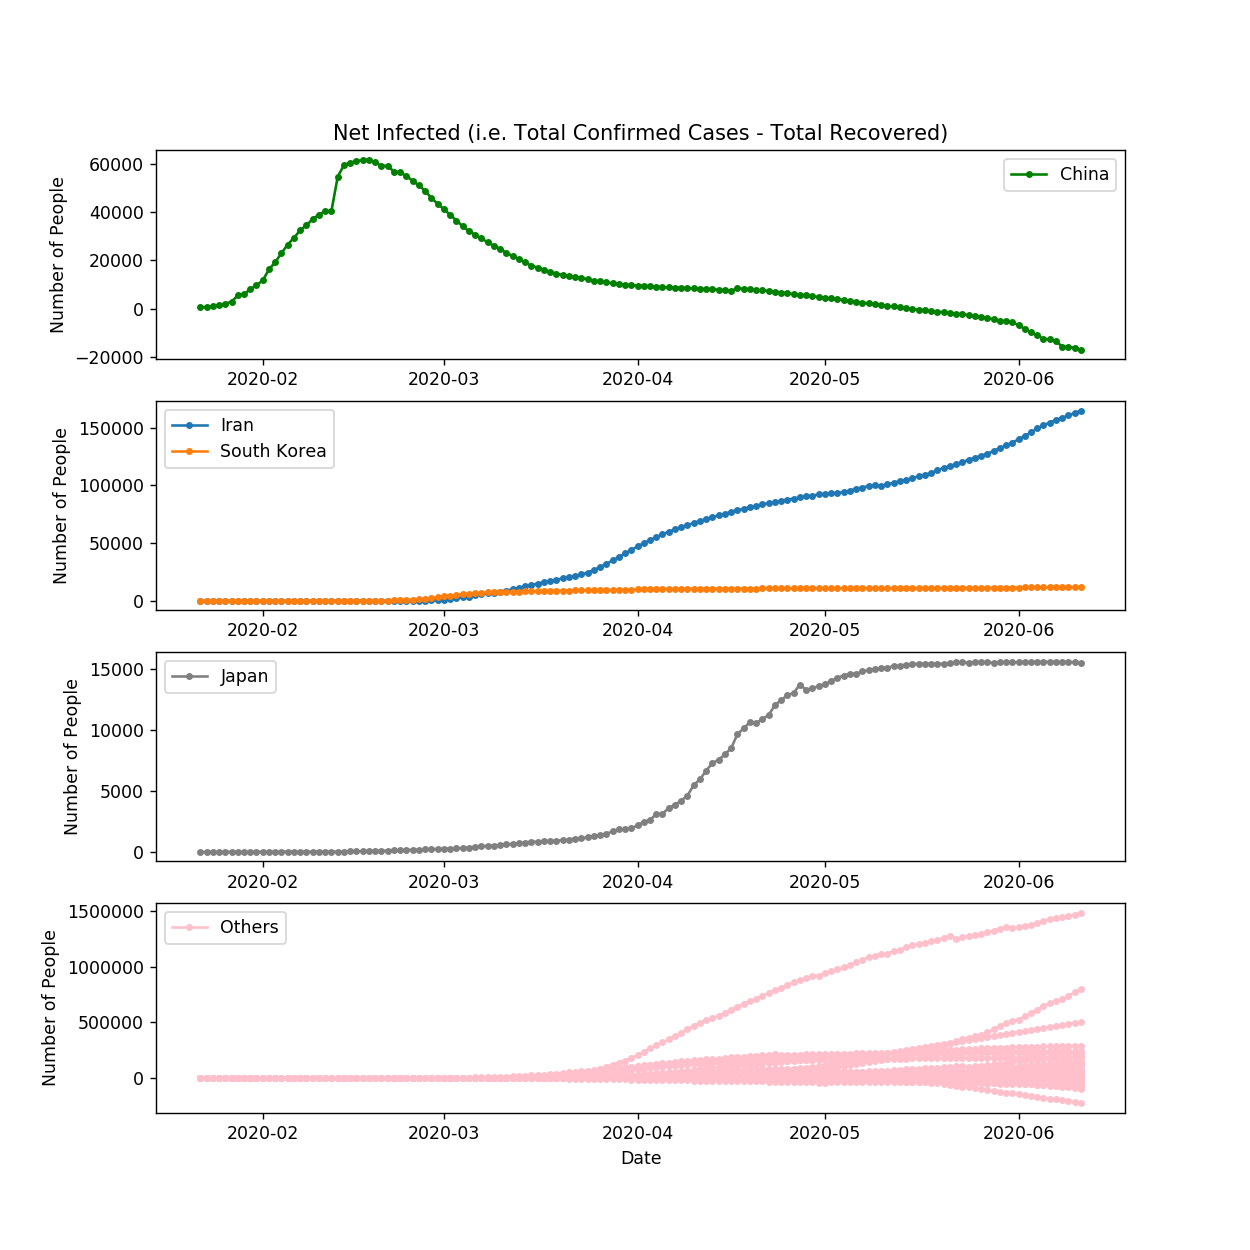

C:\Users\shasa\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


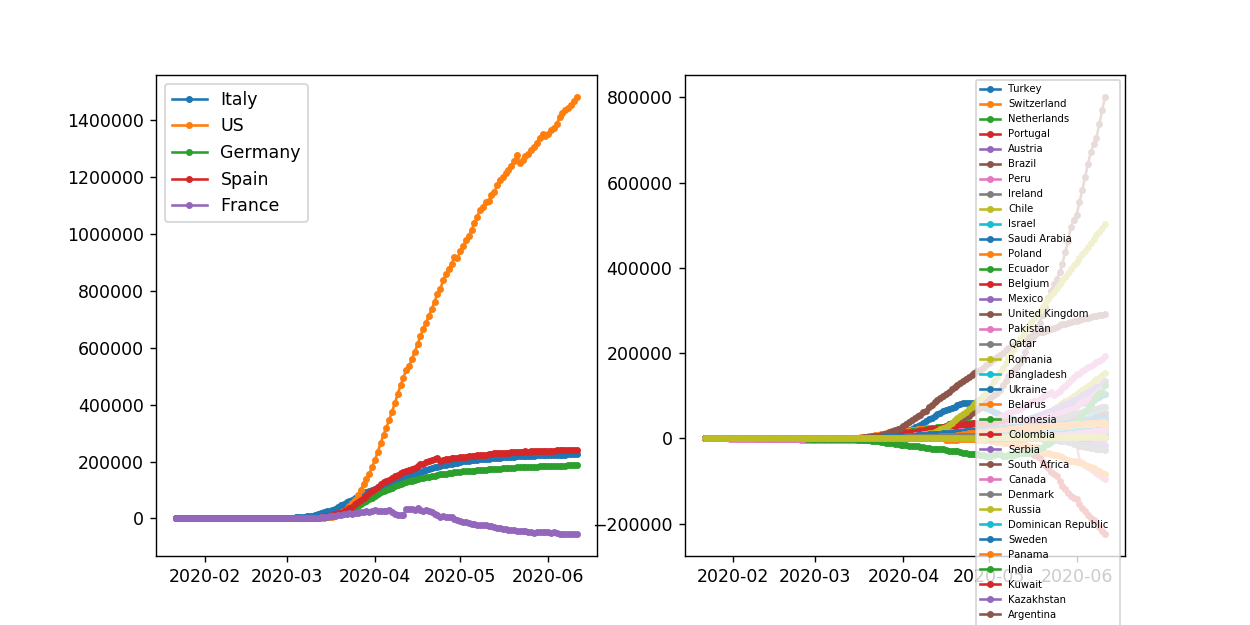

In [20]:
top_n = -1
countries = list(df_imp_dates.iloc[3,:].sort_values(ascending=True)[:-1].keys())

plt.close('all')
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(df_net_infected['China'], marker='.', color='g')
plt.ylabel('Number of People')
plt.title('Net Infected (i.e. Total Confirmed Cases - Total Recovered)')
plt.legend(['China'])

plt.subplot(412)
plt.plot(df_net_infected['Iran'], marker='.')
plt.plot(df_net_infected['Korea, South'], marker='.')
plt.ylabel('Number of People')
plt.legend(['Iran', 'South Korea'])

plt.subplot(413)
plt.plot(df_net_infected['Japan'], marker='.', color='grey')
plt.ylabel('Number of People')
plt.legend(['Japan'])

plotted = ['China', 'Iran', 'Cruise Ship', 'Korea, South', 'Japan']
plt.subplot(414)
plt.xlabel('Date')
plt.ylabel('Number of People')
for c in countries:
    if c in plotted:
        continue
    else:
        plt.plot(df_net_infected[c], marker='.', color='pink')
plt.legend(['Others'])

high_net = ['Italy', 'US', 'Germany', 'Spain', 'France']
plt.figure(figsize=(10,5))
plt.subplot(121)
for c in high_net:
    plt.plot(df_net_infected[c], marker='.')
plt.legend(high_net)

plt.subplot(122)
others = []
for c in countries:
    if c in plotted or c in high_net:
        continue
    else:
        plt.plot(df_net_infected[c], marker='.')
        others.append(c)
plt.legend(others, fontsize='xx-small')

In [27]:
def show_ts(country, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.plot(df_c_cum[country], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Confirmed Cases')
    plt.title('Total Confirmed COVID-19 Cases in ' + country)
    plt.figure(figsize=figsize)
    plt.plot(df_r_cum[country], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Recovered Cases')
    plt.title('Total Recovered from COVID-19 in ' + country)
    plt.figure(figsize=figsize)
    plt.plot(df_d_cum[country], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Deaths')
    plt.title('Total Deaths due to COVID-19 in ' + country)

<IPython.core.display.Javascript object>


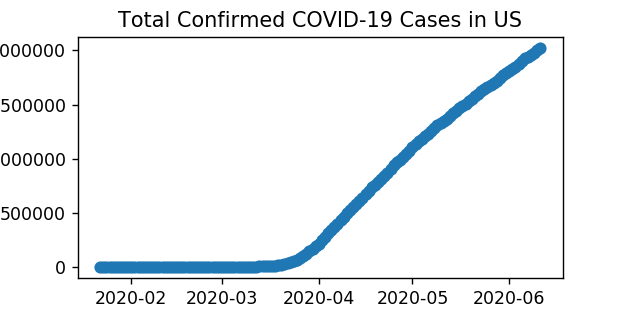

<IPython.core.display.Javascript object>


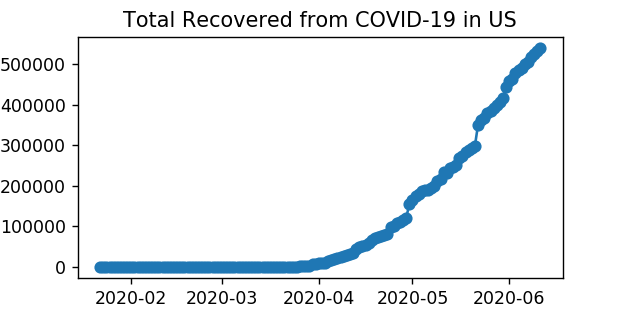

<IPython.core.display.Javascript object>


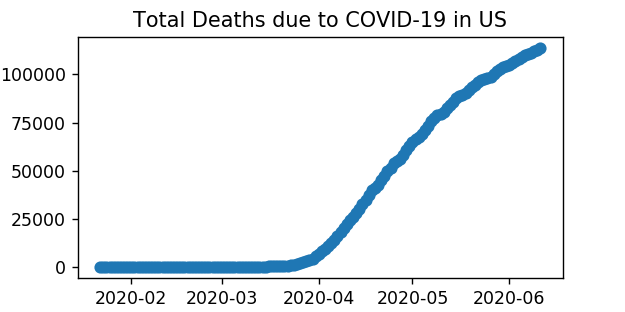

In [34]:
show_ts('US', (5,2.5))

<IPython.core.display.Javascript object>


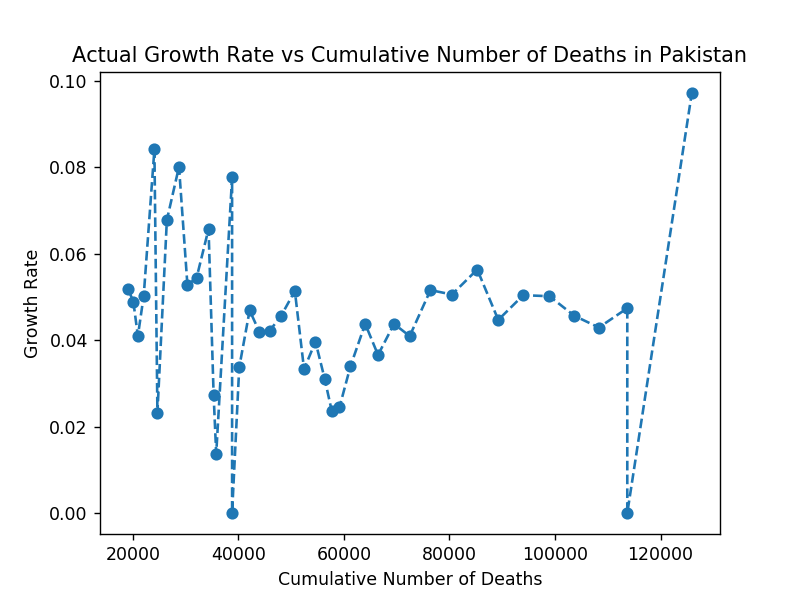

Text(0.5, 1.0, 'Actual Growth Rate vs Cumulative Number of Deaths in Pakistan')

In [41]:
country = 'Pakistan'
plt.figure()
plt.plot(df_c_cum[country].iloc[100:], df_c_growth[country].iloc[100:], linestyle='--', marker='o')
plt.xlabel('Cumulative Number of Deaths')
plt.ylabel('Growth Rate')
plt.title('Actual Growth Rate vs Cumulative Number of Deaths in ' + country)
# can't compute 'growth' at day 0 (taken as 1 here if growth_period=1)

0.8106843574485911
lamda0: 0.16593845574448848 
N_inf: 97321.59569093827 
N0: 100


<IPython.core.display.Javascript object>


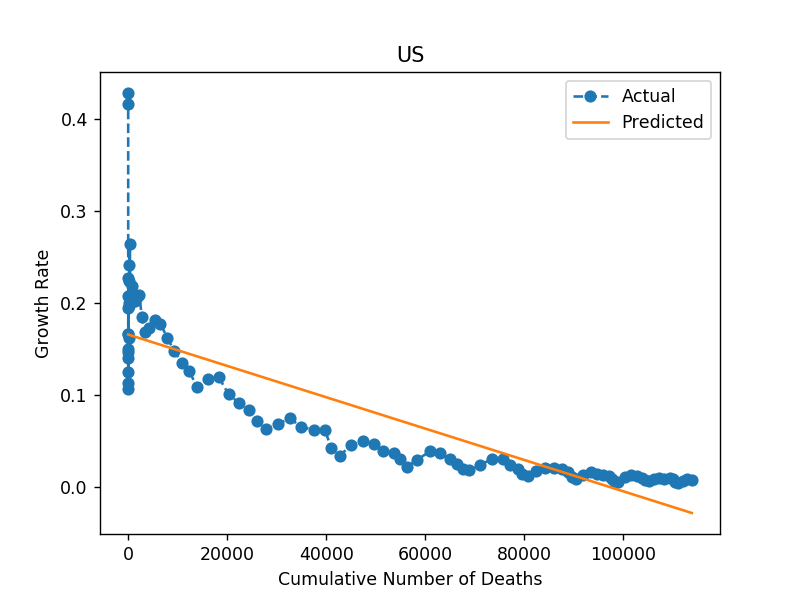

In [45]:
# Predictions
country = 'US'

outbreak_start_date = df_d_cum[country].ne(0).idxmax()
outbreak_start_index = df_d_cum.index.get_loc(outbreak_start_date)
growth_period = 2
linear_after = 14  # days after which linear trend observed (lockdown date for Italy)
# 14 works for China and Iran, but have to come up with something generic

# first 2 values not inappropriate for growth which is computed as average difference between cumulative deaths over growth_period (i.e. 2 here) number of days
# thus, starting from outbreak_start_index+2
# scikit learn regression expects 2D array instead of 1D array, therefore reshaping necessary
X = df_d_cum[country].iloc[outbreak_start_index+growth_period:].values.reshape(-1,1)
y = df_d_growth[country].iloc[outbreak_start_index+growth_period:].values.reshape(-1,1)

# training only once linear phase is reached
X_train = df_d_cum[country].iloc[outbreak_start_index+growth_period+linear_after:].values.reshape(-1,1)
y_train = df_d_growth[country].iloc[outbreak_start_index+growth_period+linear_after:].values.reshape(-1,1)
# not using any test set, and making it explicit through naming

reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X)

print(reg.score(X_train, y_train))
m, lamda0 = float(reg.coef_), float(reg.intercept_)
N0 = df_d_cum[country].iloc[outbreak_start_index+growth_period+linear_after]
N_inf = abs(lamda0/m)

print('lamda0:', lamda0, '\nN_inf:', N_inf, '\nN0:', N0)

plt.close('all')
plt.figure()
plt.plot(df_d_cum[country].iloc[outbreak_start_index+growth_period:], df_d_growth[country].iloc[outbreak_start_index+growth_period:], linestyle='--', marker='o')
plt.plot(X, pred)
plt.xlabel('Cumulative Number of Deaths')
plt.ylabel('Growth Rate')
plt.title(country)
plt.legend(['Actual', 'Predicted'])